In [1]:
import autograd.numpy as np

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import random
import matplotlib.pyplot as plt
from autograd import grad
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image
from scipy.signal import find_peaks
from sklearn.preprocessing import MinMaxScaler

from numpy.fft import *
import matplotlib.style as style 
style.use('ggplot')

# import function flattening module from autograd
from autograd.misc.flatten import flatten_func

import math

In [2]:
data = np.loadtxt('../data/test.csv',delimiter = ' ')[0]

In [3]:
#function to filter out frequencies in signal that are above the threshold
def filter_signal(signal, threshold=5e3):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

In [4]:
#Plot of a clean window of data
clean_data = data[:20000]

# plt.figure(figsize=(35,5))
# plt.plot(clean_data)
# plt.show()

In [5]:
scaler = MinMaxScaler(feature_range=(0, 5)) #init scaler, scales between 0 and 5
Y_old = scaler.fit_transform(np.asarray([i for i in range(len(clean_data)+1)]).reshape(-1,1)) #generate supervised output data

#plot the output with points for ints - represents the end of a cycle and an increment in count
# plt.figure(figsize=(35,5))
# plt.plot(Y_old)
# plt.scatter([4000,4000*2,4000*3,4000*4,4000*5],[1,2,3,4,5],color='Black')
# plt.show()

In [6]:
actions = np.asarray([filter_signal(clean_data)[:4001]]) #X - equivalent to actions
states = np.asarray(Y_old[:4001].copy()).T #Y - equivalent to states

x_new = np.asarray([actions[0][:4001]])
y_new = np.asarray([states[0][:4001]])

print(x_new.shape)
print(y_new.shape)

(1, 4001)
(1, 4001)


In [65]:
#Linear Model
def model3(theta,m2_result,mprev): 
    #trying to give the flattened line a linear shape, why wont this work!!!!!!
    return theta[7]+theta[8]*mprev+theta[9]*m2_result+theta[10]*(mprev**2)+theta[11]*(m2_result**2)

#Exponential Averaging Model
def model2(theta,p,m1,mprev):
    #return ((theta[7]-1)/(theta[7]))*mprev + (1/theta[7])*m1
    temp2 = ((p-1)/(p))*mprev + (1/p)*m1 #p is a the index of current value
    return model3(theta,temp2,mprev)

#Transform Model
def model(theta,a_t,prev_out,c):
#     return theta[0]*prev_out + (1-theta[0])*a_t + theta[1]
#     return theta[0]*prev_out + theta[1]*a_t 
#     return theta[0]*prev_out + math.log(prev_out,theta[1]) + theta[2]*a_t + math.log(prev_out,theta[3])
#     return theta[0]*prev_out + np.log(prev_out) / np.log(theta[1]) + theta[2]*a_t + np.log(a_t) / np.log(theta[3])
#     return theta[0]*prev_out + theta[2]*a_t + theta[3]
#     return theta[0]*prev_out**theta[1] + theta[2]*a_t 

    temp = theta[0] + theta[1]*np.sin(theta[2]*prev_out) + theta[3]*np.sin(theta[4]*a_t) + theta[5]*prev_out + theta[6]*a_t
    return model2(theta,c,temp,prev_out)

#     return theta[0]+theta[1]*prev_out+theta[2]*a_t+ prev_out**(.5+theta[3])+a_t**(.5+theta[4])


# loop for training model over all input/output action/state pairs
def loop(theta,s,a, prev_out):
    pr = prev_out
    # compute least squares over all imitator model outputs at once
    s_predict = [s[:,0]]  # container for system_model state outputs
    count=0
    for t in range(a.shape[1]-1):
        count+=1
        # get current action-state pair
        s_t = s[:,t]
        a_t = a[:,t]

        # feed into system_model to get predicted output
        modelout = model(theta,a_t,pr,count)
        s_hat = modelout
        
        # store prediction
        s_predict.append(s_hat)
        pr = s_hat
        
    # array-afy predictions and return
    return np.array(s_predict).T

# an implementation of the least squares cost for system identification
# note here: s is an (1 x T) array and a an (1 x T-1) array
def least_squares(theta,s,a):
#     print("Least Squares Called.")
    # loop - runs over all action-state pairs and produces entire
    # state prediction set
    p = 0.1
    s_predict1 = loop(theta,s,a,p)
#     s_predict = loop2(theta,s,a)
    
    # compute least squares error between real and predicted states
    cost = np.sum((s_predict1[:,1:] - s[:,1:])**2)
    return cost/float(s.shape[1]-1)

# a simple initializer for this model
def initializer():
    return 1e-1*np.random.randn(12,1)
#     return np.ones((8,1))
#     return np.array([[5]])

#1+2*maxits calls to least square
def gradient_descent(g,alpha,max_its,w): 
    # compute gradient module using autograd
    gradient = grad(g)

    # run the gradient descent loop
    weight_history = [w] # weight history container
#     cost_history = [g(w,actions,states)]
    cost_history = [g(w,states,actions)]
    
    for k in range(max_its):

#         if 5%5==0: print("Iteration",k)
        print("Iteration",k)
            
        # evaluate the gradient
#         grad_eval = gradient(w,actions,states)
        grad_eval = gradient(w,states,actions)

        # take gradient descent step
        w = w - alpha*grad_eval
        
        # record weight and cost
        weight_history.append(w)
#         cost_history.append(g(w,actions,states))
        cost_history.append(g(w,states,actions))
        
    return weight_history,cost_history

In [74]:
g=least_squares;
w=initializer();
k=10; alph=1e-1;
weight_history_1,cost_history_1 = gradient_descent(g,alph,k,w)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9


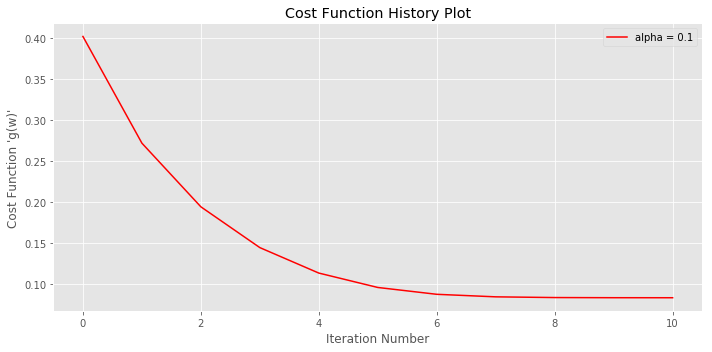

In [75]:
fig = plt.figure(figsize=(10,5))
plt.plot(range(len(cost_history_1)),cost_history_1,c='red',label='alpha = '+str(alph))
plt.legend(loc='upper right')
plt.title("Cost Function History Plot")
plt.xlabel("Iteration Number")
plt.ylabel("Cost Function 'g(w)'")
plt.show()

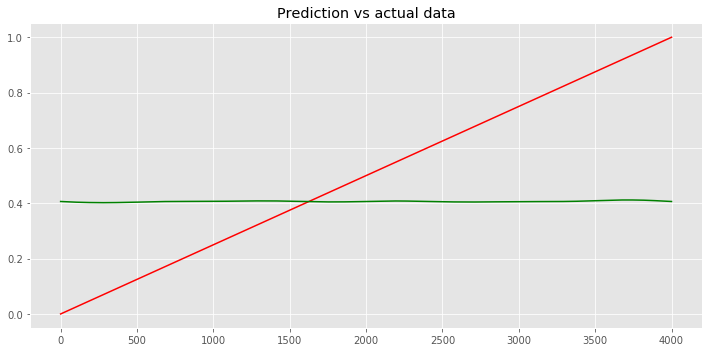

In [76]:
w1 = weight_history_1[-1]
p = 0.1
sp=[]
mywave=[]
count=0
for i in x_new:
    count+=1
    temp = model(w1,i,p,count)
    mywave.append(temp)
    #sp.append(mywave)
    p = temp

# mywave= [model(w1,x_new,p)]

fig = plt.figure(figsize=(10,5))

plt.plot(y_new[0],c='red')
plt.plot(mywave[0],c="green")

plt.title("Prediction vs actual data")
plt.show()

In [77]:
weight_history_1

[array([[ 0.19842832],
        [ 0.04968514],
        [ 0.12224009],
        [-0.05161767],
        [ 0.00339537],
        [-0.03811184],
        [-0.04140225],
        [-0.06006325],
        [ 0.11382058],
        [-0.03908503],
        [-0.02298823],
        [ 0.04758656]]), array([[ 0.19842461],
        [ 0.04968517],
        [ 0.12224011],
        [-0.05161767],
        [ 0.0033954 ],
        [-0.03811161],
        [-0.04140288],
        [ 0.06163939],
        [ 0.10593341],
        [-0.04695078],
        [-0.022477  ],
        [ 0.0480953 ]]), array([[ 0.19842364],
        [ 0.04968516],
        [ 0.1222401 ],
        [-0.05161767],
        [ 0.00339537],
        [-0.03811167],
        [-0.0414023 ],
        [ 0.15432225],
        [ 0.11201498],
        [-0.04086558],
        [-0.02207795],
        [ 0.04849474]]), array([[ 0.19842424],
        [ 0.04968517],
        [ 0.12224011],
        [-0.05161766],
        [ 0.00339532],
        [-0.03811158],
        [-0.04140139],
        